In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import random
import numpy as np
import torch as ch
from glob import glob
from copy import deepcopy
from collections import Counter
from IPython.display import display

import sys
sys.path.append("../src/")
import utils
import matplotlib.pyplot as plt
from robustness_analyzer import RobustnessAnalyzer

### Camera Perturbation

In [3]:
data_dir = "../data"

# Envmap(s) we're using during optimization (one or more)
envmap_paths = glob(os.path.join("../data", "environments_sky/*"))[:4]
envmap_paths = []  # This would generate background-neutral (white) renders

true_class = "airliner" 
target_class = "airliner"  

params_to_optimize = ["camera"]

kwargs = {
    "obj_path": os.path.join(data_dir, "airplane/mesh.obj"),
    "texture_path": os.path.join(data_dir, "airplane/texture.png"),
    "envmap_paths": envmap_paths,
    "target_class": target_class,
    "batch_size": 50,  # How many different viewpoints we're optimizing in parallel (* #Environments)
    "params_to_optimize": params_to_optimize,
    "targeted": target_class!=true_class
}

robust_analyzer = RobustnessAnalyzer(**kwargs)

#### Run optimization: This will generate num_runs*batch_size viewpoints
results_camera = robust_analyzer.run(num_runs=50, num_iterations=200, lr=1e-1)

Loss: 2.13 - Class: airliner        - 'adv acc': 24/50 - Avg Prob: 0.4393 - LR: 1.00e-01: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [02:58<00:00,  1.12it/s]
Loss: 2.61 - Class: airliner        - 'adv acc': 22/50 - Avg Prob: 0.4297 - LR: 1.00e-01: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [02:57<00:00,  1.13it/s]
Loss: 2.49 - Class: airliner        - 'adv acc': 25/50 - Avg Prob: 0.4429 - LR: 1.00e-01: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

Loss: 1.88 - Class: airliner        - 'adv acc': 22/50 - Avg Prob: 0.4651 - LR: 1.00e-01: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [02:57<00:00,  1.12it/s]
Loss: 2.39 - Class: airliner        - 'adv acc': 20/50 - Avg Prob: 0.4689 - LR: 1.00e-01: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [02:57<00:00,  1.12it/s]
Loss: 2.38 - Class: airliner        - 'adv acc': 22/50 - Avg Prob: 0.4676 - LR: 1.00e-01: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

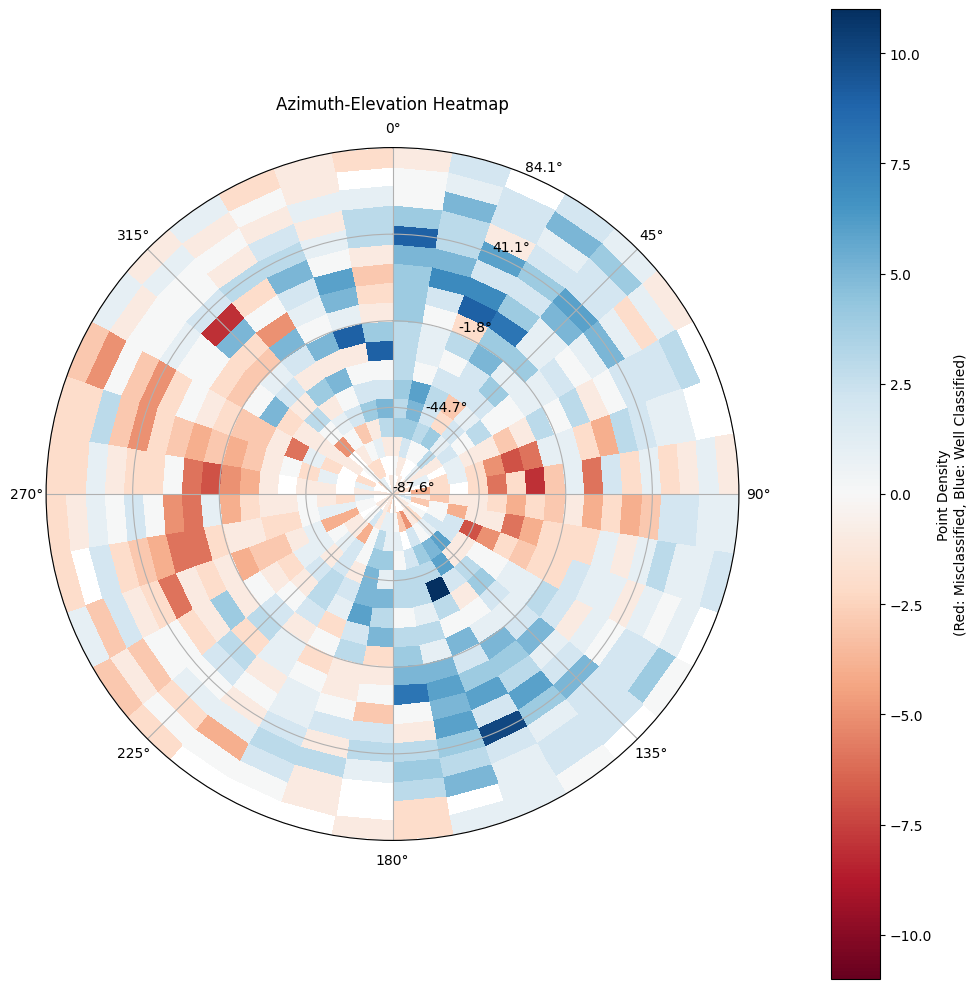

In [68]:
labels_correct = ch.stack(results_camera["final_logits"]).reshape(-1, 1000).argmax(1) == utils.get_idx("airliner")

camera_positions = ch.stack([x["camera"] for x in results_camera["final_scene_params"]]).reshape(-1, 3)
utils.visualize_positions_polar(camera_positions, labels_correct)

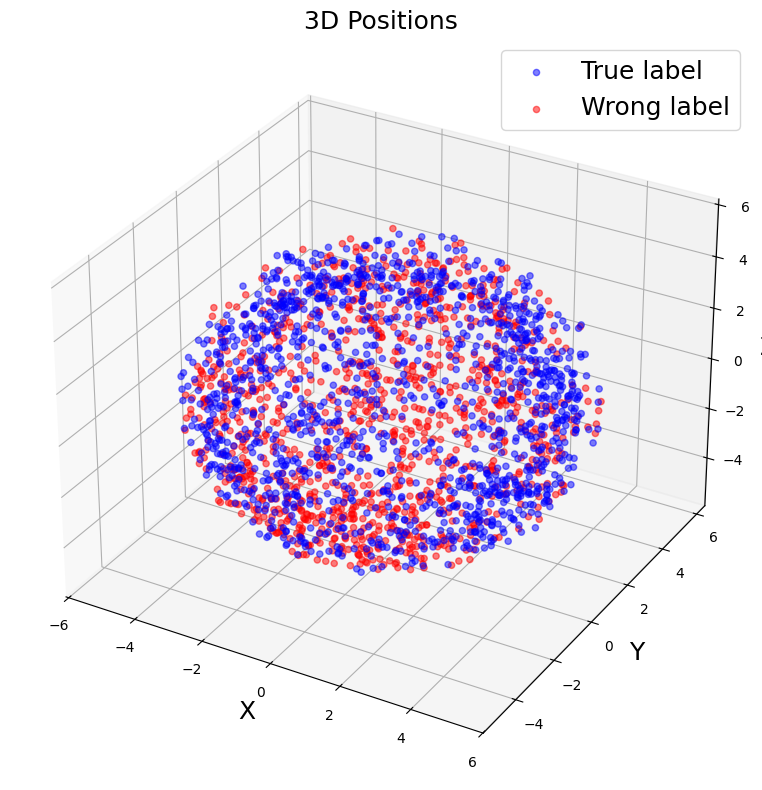

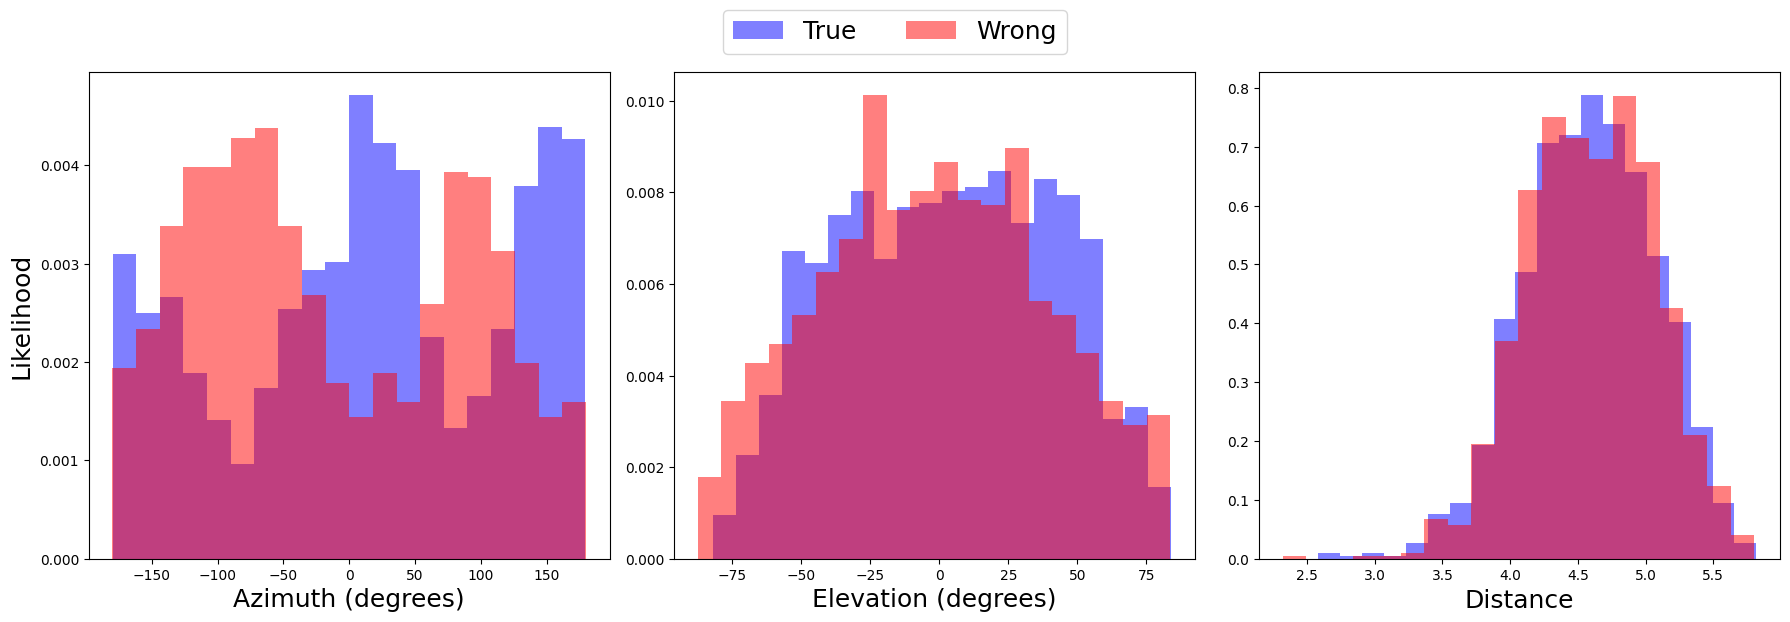

In [69]:
utils.visualize_positions_with_distributions(camera_positions, labels_correct)

If we want to re-render a specific output we can do it this way, here showing specific examples from the problematic areas from the distribution for Azimuth

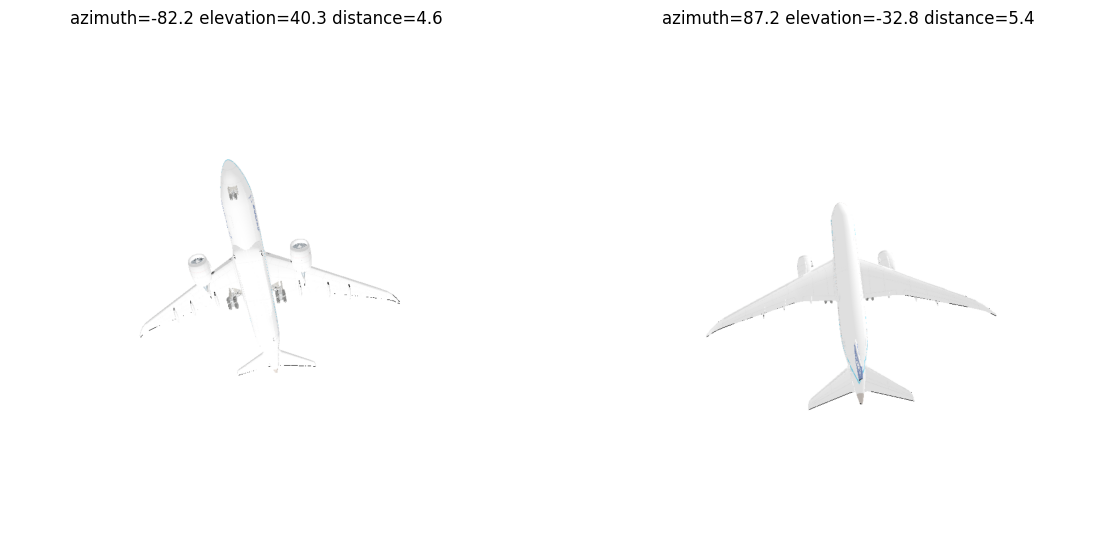

In [109]:
# Recreate a specific run rendering outputs from the saved scene params state
run_nb = 0
model = deepcopy(robust_analyzer.model)
model.update_scene_params(results_camera["final_scene_params"][run_nb])

render_ims = model.render(image_res=224*4)

fig, axes = plt.subplots(1, 2, figsize=(14, 7))
for ax, im_idx in zip(axes.flatten(), [4, 7]):
    title=" ".join([f"{metric}={x.item():.1f}" for x, metric in 
           zip(utils.compute_spherical_coordinates(results_camera["final_scene_params"][run_nb]["camera"][im_idx][None]),
              ["azimuth", "elevation", "distance"])])
    ax.imshow(utils.to_numpy(render_ims[im_idx][0])) # First idx for batch (50 here), second idx for environment (1 here)
    ax.axis("off")
    ax.set_title(title)

### Texture Perturbation

- Same config and parameters in `kwargs` except for `args_to_optimize` that we set to 'texture'.
- Across a batch, the texture is consistent as we want to find textures color failures to the model independent of the viewpoint, so behind the scenes, after each backward pass, we average the texture gradients from each texture. So in total we will have up to `num_runs` adversarial textures.

In [21]:
# Envmap(s) we're using during optimization (one or more)
envmap_paths = glob("environments_sky/*")[:1]

true_class = "airliner" 
target_class = "airliner"  


params_to_optimize = ["texture"]

kwargs = {
    "obj_path": "airplane/mesh.obj",
    "texture_path": "airplane/texture.png",
    "envmap_paths": envmap_paths,
    "target_class": target_class,
    "batch_size": 25,
    "params_to_optimize": params_to_optimize,
    "targeted": target_class!=true_class
}

robust_analyzer = RobustnessAnalyzer(**kwargs)

#### Run optimization: This will generate 50 (num_runs) potentially adversarial textures
results_texture = robust_analyzer.run(num_runs=10, num_iterations=100)

Loss: 1.23 - Class: airliner        - 'adv acc': 9/25 - Avg Prob: 0.5339 - LR: 1.00e-01: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:55<00:00,  1.15s/it]
Loss: 3.33 - Class: airliner        - 'adv acc': 17/25 - Avg Prob: 0.2046 - LR: 1.00e-01: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:54<00:00,  1.15s/it]
Loss: 3.01 - Class: airliner        - 'adv acc': 17/25 - Avg Prob: 0.2492 - LR: 1.00e-01: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

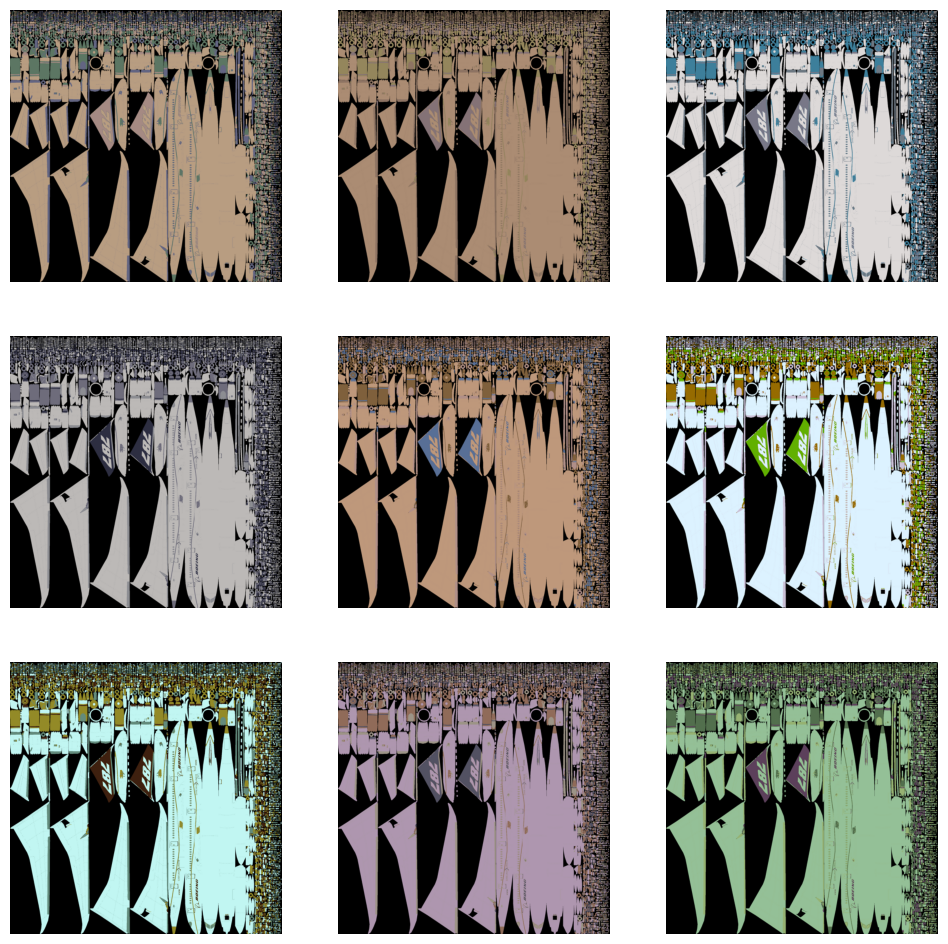

In [15]:
### View of some of the adversarial textures
fig, axes = plt.subplots(3, 3, figsize=(12, 12)) 

for idx, ax in enumerate(axes.flatten()):
    texture = results_texture["final_texture"][idx][0].clip(0, 1)
    
    # downsize for faster plotting
    ax.imshow(utils.resize(texture, size=(512, 512)))
    ax.axis("off")

### Light Perturbation

In [24]:
# Envmap(s) we're using during optimization (one or more)
envmap_paths = glob("environments_sky/*")[:1]
envmap_paths = [] # will use gray 

true_class = "airliner" 
target_class = "airliner"  


params_to_optimize = ["lighting"]

kwargs = {
    "obj_path": "airplane/mesh.obj",
    "texture_path": "airplane/texture.png",
    "envmap_paths": envmap_paths,
    "target_class": target_class,
    "batch_size": 25,  # How many different viewpoints we're optimizing in parallel (* #Environments)
    "params_to_optimize": params_to_optimize,
    "targeted": target_class!=true_class
}

robust_analyzer = RobustnessAnalyzer(**kwargs)

#### Run optimization: This will generate 50 (num_runs) potentially adversarial textures
results_lighting = robust_analyzer.run(num_runs=5, num_iterations=100)

Loss: 5.07 - Class: airliner        - 'adv acc': 17/25 - Avg Prob: 0.3007 - LR: 1.00e-01: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:41<00:00,  2.44it/s]
Loss: 5.55 - Class: airliner        - 'adv acc': 18/25 - Avg Prob: 0.2637 - LR: 1.00e-01: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:41<00:00,  2.42it/s]
Loss: 7.42 - Class: airliner        - 'adv acc': 22/25 - Avg Prob: 0.1147 - LR: 1.00e-01: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

Similar to for the Camera position, we can plot the 3d light position after optimization to see if there is any light angle that is problematic

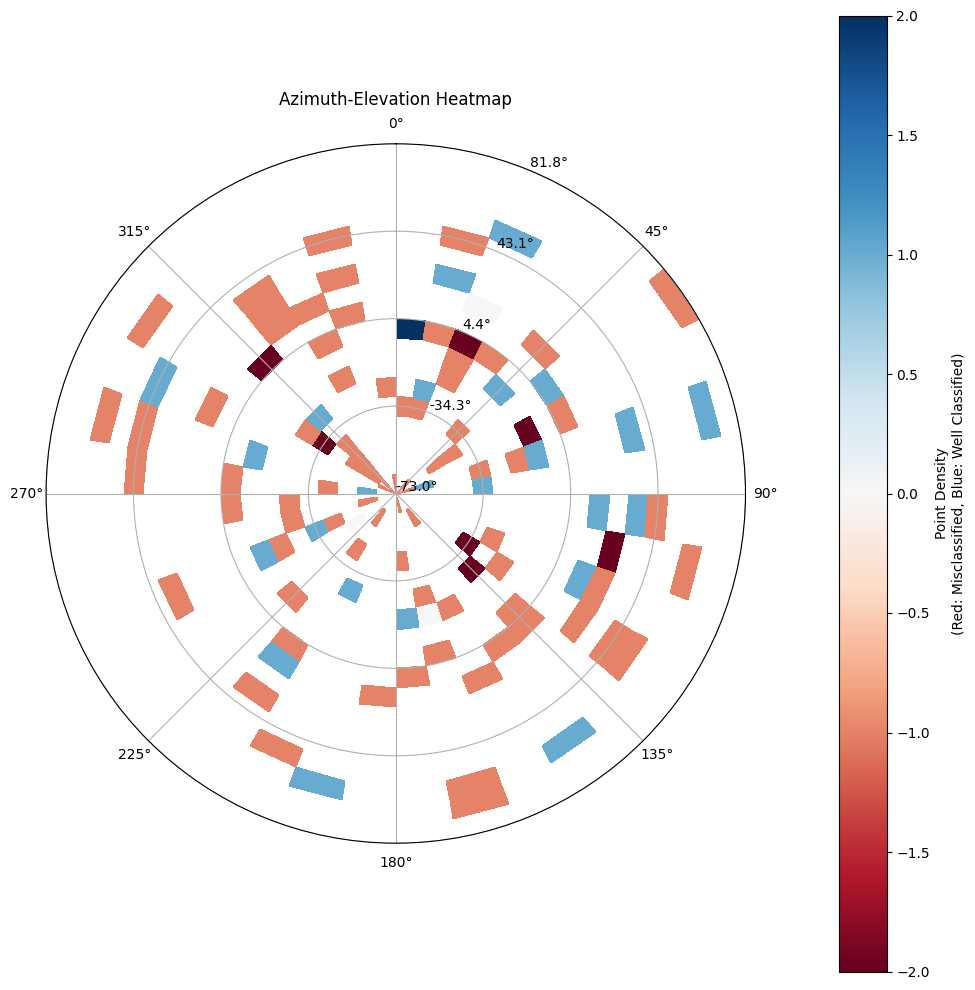

In [76]:
labels_correct = ch.stack(results_lighting["final_logits"]).reshape(-1, 1000).argmax(1) == utils.get_idx("airliner")

light_positions = ch.stack([x["light_location"] for x in results_lighting["final_scene_params"]]).reshape(-1, 3)
utils.visualize_positions_polar(light_positions, labels_correct)

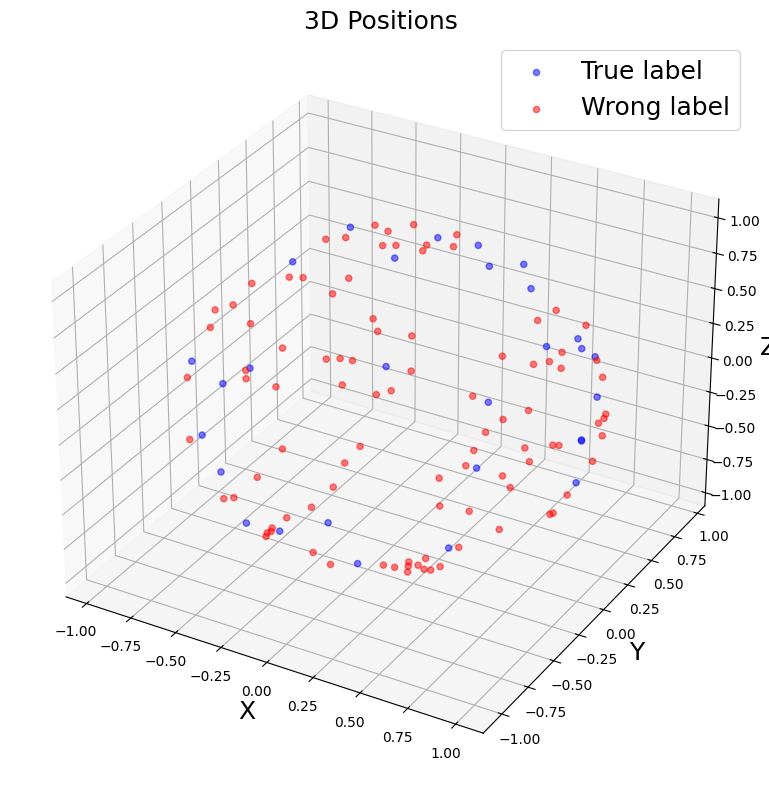

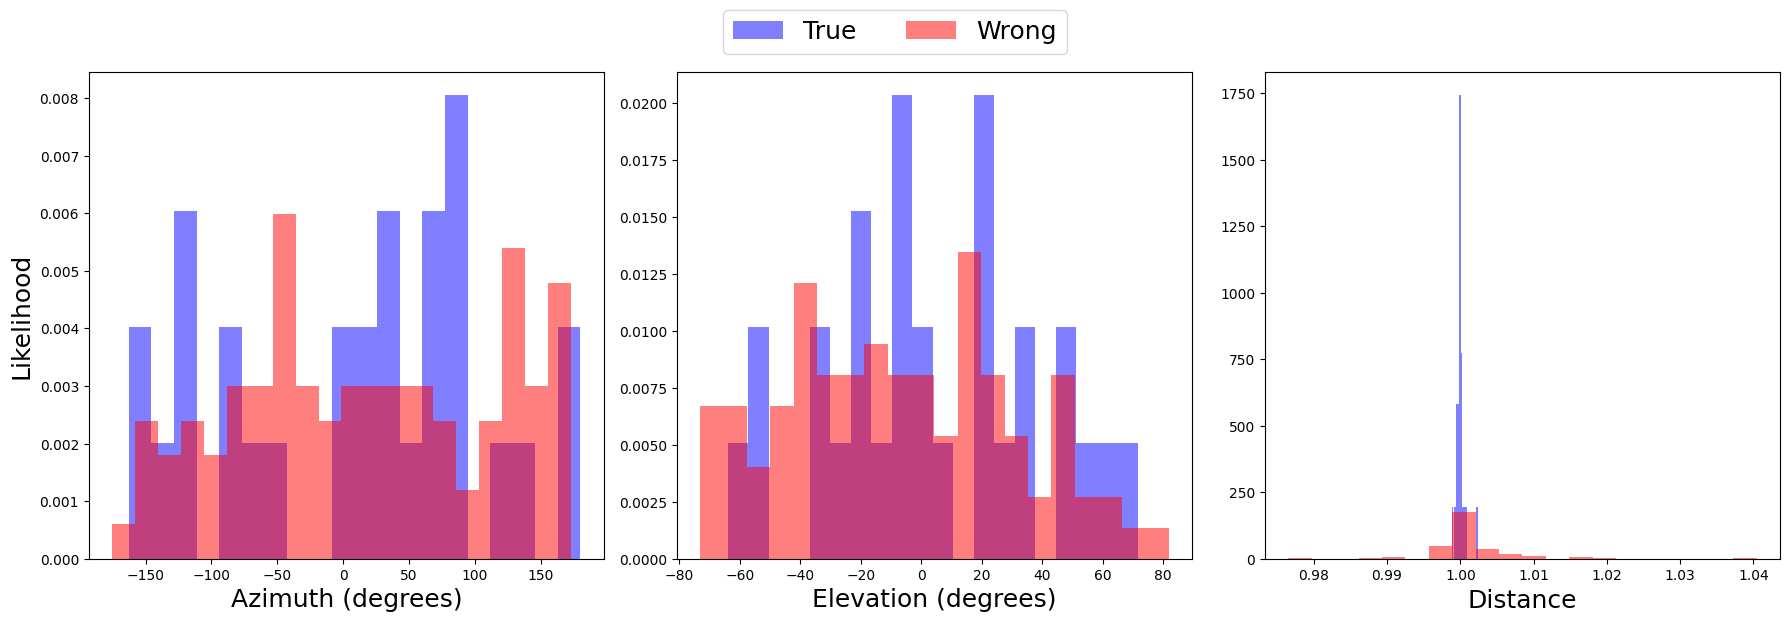

In [77]:
utils.visualize_positions_with_distributions(light_positions, labels_correct)

### General Plots 

In [25]:
all_results = {"camera": results_camera, "texture": results_texture, "lighting": results_lighting}

Along with the adversarial scene parameters after optimization, we save a batch-average (cross-entropy) loss during the optimization and the average probability (after softmax) of the `target class`

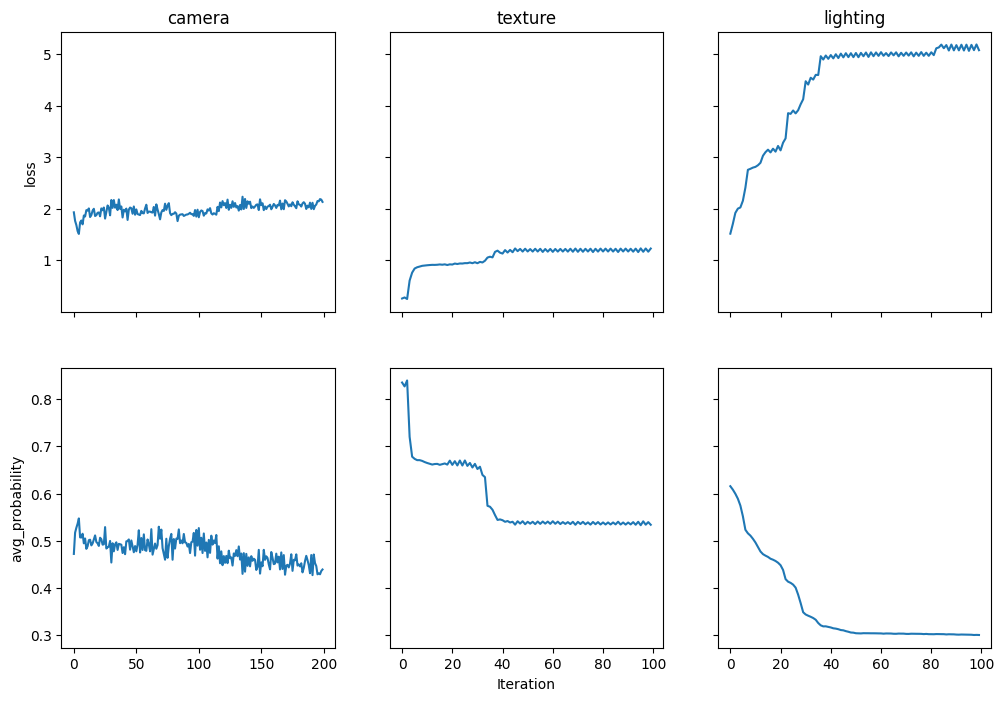

In [26]:
### To visualize Loss and Average Probability of target class during optimization
fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharey="row", sharex="col")

run_idx = 0 # choose one of the runs
for i, metric in enumerate(["loss", "avg_probability"]):
    for j, (type_, results) in enumerate(all_results.items()):
        ax = axes[i][j]
        if i == 0: ax.set_title(type_)
        if j == 0: ax.set_ylabel(metric)
        if i == 1 and j == 1: ax.set_xlabel("Iteration")
        ax.plot(results[metric][run_idx])

In [78]:
### Classification Stats overview between start and end of optimization
from IPython.display import display, HTML

target_class = kwargs["target_class"]

# Build HTML for side-by-side tables
html_table = "<table>"

# Header
html_table += """
<tr>
    <th></th>
    <th style="text-align: center;">Initial</th>
    <th style="text-align: center;">Final</th>
</tr>
"""

for i, (type_, results) in enumerate(all_results.items()):
    initial_analysis = utils.analyze_logits_detailed(
        np.concatenate(results["initial_logits"]).reshape(-1, 1000), target_class
    )
    final_analysis = utils.analyze_logits_detailed(
        np.concatenate(results["final_logits"]).reshape(-1, 1000), target_class
    )
    
    html_table += f"""
    <tr">
        <td>{type_.capitalize()}</td>
        <td>{initial_analysis.to_html()}</td>
        <td>{final_analysis.to_html()}</td>
    </tr>
    """

html_table += "</table>"
display(HTML(html_table))

This highlights for each kind of scene perturbation, what are the most common failures/misslassifications.